In [1]:
import networkx as nx
import pyalex
from pyalex import Works, Institutions, Topics, Funders
from collections import Counter
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import chain
import numpy as np
import scipy
pyalex.config.email = "aymann.mhammedi@gmail.com"

In [2]:
# Fetch a list of topics
topics = Topics().get()

# Print the list of topics with their IDs and display names
#for topic in topics:
#   print(f"ID: {topic['id']}, Display Name: {topic['display_name']}, Description: {topic['description']}")

In [3]:
funders = Funders().get()
# List fields of funders object
print(funders[0].keys())

dict_keys(['id', 'display_name', 'alternate_titles', 'country_code', 'description', 'homepage_url', 'image_url', 'image_thumbnail_url', 'grants_count', 'works_count', 'cited_by_count', 'summary_stats', 'ids', 'counts_by_year', 'roles', 'updated_date', 'created_date'])


In [4]:
# Define the filter criteria for works published in the USA in 2015
filter_criteria = {
    "from_publication_date": "2016-01-01",  # Start date
    "to_publication_date": "2020-12-31",    # End date
    "institutions": {"country_code": "us"},  # Filter for U.S.-based institutions
    "primary_location": {"source": {"type": "journal"}},  # Filter for journal articles
    "primary_topic": {"subfield": {"id": 2740}},  # Filter for Pulmonary and Respiratory Medicine
}


# Fetch the works with pagination
query = Works().filter(**filter_criteria)
all_works_16_20 = list(chain.from_iterable(query.paginate(per_page=200, n_max=None)))  # Adjust per_page as needed, n_max=None for all papers (heavy)

# Count the number of works
num_works_16_20 = len(all_works_16_20)

# Print the number of works
print(f"Number of works published in the USA in between 2016-2020: {num_works_16_20}")

# Optionally, print the first few works to verify
for work in all_works_16_20[:5]:  # Print the first 5 works as an example
    print(f"ID: {work['id']}, Title: {work['title']}, Publication Year: {work['publication_year']}")

Number of works published in the USA in between 2016-2020: 99294
ID: https://openalex.org/W2762087180, Title: Ferroptosis: A Regulated Cell Death Nexus Linking Metabolism, Redox Biology, and Disease, Publication Year: 2017
ID: https://openalex.org/W2286228001, Title: Epidemiology, Patterns of Care, and Mortality for Patients With Acute Respiratory Distress Syndrome in Intensive Care Units in 50 Countries, Publication Year: 2016
ID: https://openalex.org/W2770828094, Title: Osimertinib in Untreated<i>EGFR</i>-Mutated Advanced Non–Small-Cell Lung Cancer, Publication Year: 2017
ID: https://openalex.org/W2792937256, Title: Nivolumab plus Ipilimumab versus Sunitinib in Advanced Renal-Cell Carcinoma, Publication Year: 2018
ID: https://openalex.org/W2228221433, Title: The IASLC Lung Cancer Staging Project: Proposals for Revision of the TNM Stage Groupings in the Forthcoming (Eighth) Edition of the TNM Classification for Lung Cancer, Publication Year: 2016


In [5]:
# Create all_works_2018 with only works from 2018
all_works_2018 = [work for work in all_works_16_20 if work['publication_year'] == 2018]
num_works = len(all_works_2018)

In [6]:
# Count the number of unique work IDs
unique_work_ids = len(set(work['id'] for work in all_works_2018))

# Print the result
print(f"Number of unique work IDs: {unique_work_ids}")

Number of unique work IDs: 19382


## Collaboration coauthorship

In [7]:
# Construct a collaboration network with country information
G_collaboration = nx.Graph()

# Add nodes and edges for authors
for work in all_works_2018:
    authors = [
        (authorship['author']['id'], authorship['countries'])  # Assuming the first country is the primary one
        for authorship in work['authorships']
    ]
    for i, (author1, country1) in enumerate(authors):
        # Add author1 node with country attribute
        G_collaboration.add_node(author1, country=country1)
        for author2, country2 in authors[i + 1:]:
            # Add author2 node with country attribute
            G_collaboration.add_node(author2, country=country2)
            # Add edge between author1 and author2
            if G_collaboration.has_edge(author1, author2):
                G_collaboration[author1][author2]['weight'] += 1
            else:
                G_collaboration.add_edge(author1, author2, weight=1)

COAUTHORSHIP

In [8]:
# Number of nodes and edges in the collaboration network
num_nodes = G_collaboration.number_of_nodes()
num_edges = G_collaboration.number_of_edges()
print(f"Number of authors in the collaboration network: {num_nodes}")
print(f"Number of edges in the collaboration network: {num_edges}")
# Mean and median edges per node
mean_edges_per_node = np.mean([G_collaboration.degree(n) for n in G_collaboration.nodes()])
median_edges_per_node = np.median([G_collaboration.degree(n) for n in G_collaboration.nodes()])
print(f"Mean number of coauthors per author: {mean_edges_per_node}")
print(f"Median number of coauthors per author: {median_edges_per_node}")

Number of authors in the collaboration network: 82789
Number of edges in the collaboration network: 716444
Mean number of coauthors per author: 17.307709961468312
Median number of coauthors per author: 9.0


In [9]:
# Degree centrality
#degree_centrality = nx.degree_centrality(G_collaboration)
#top_collaborators = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
#print("Top collaborative authors by degree centrality:", top_collaborators)

# Betweenness centrality
#betweenness_centrality = nx.betweenness_centrality(G_collaboration)
#top_intermediaries = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
#print("Top intermediaries in the network by betweenness centrality:", top_intermediaries)

# Connected components
#connected_components = list(nx.connected_components(G_collaboration))
#print(f"Number of connected components: {len(connected_components)}")

In [10]:
G_collaboration.remove_edges_from(nx.selfloop_edges(G_collaboration))

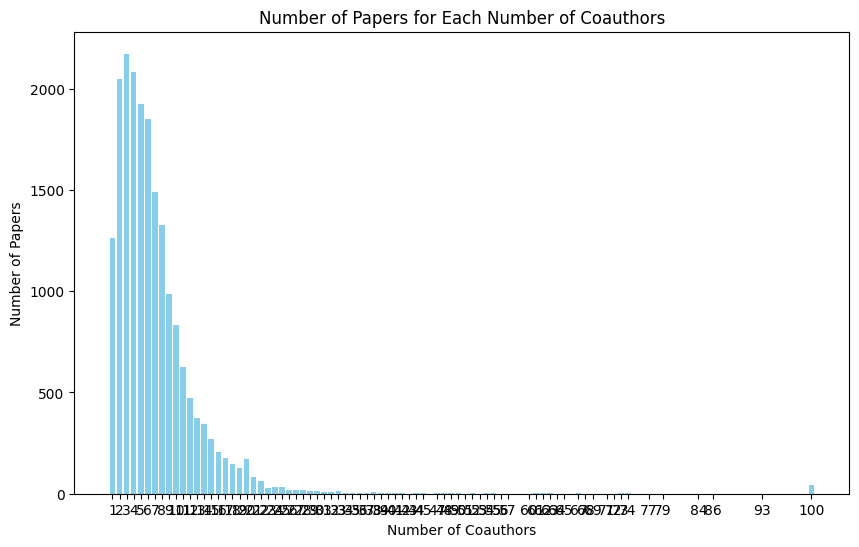

In [11]:
# Count the number of coauthors for each work
coauthor_counts = Counter(len(work['authorships']) for work in all_works_2018)

# Prepare data for plotting
coauthor_numbers = list(coauthor_counts.keys())
paper_counts = list(coauthor_counts.values())

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(coauthor_numbers, paper_counts, color='skyblue')
plt.xlabel('Number of Coauthors')
plt.ylabel('Number of Papers')
plt.title('Number of Papers for Each Number of Coauthors')
plt.xticks(coauthor_numbers)
plt.show()

In [12]:
#Mean and median number of coauthors per paper
mean_coauthors = np.mean([len(work['authorships']) for work in all_works_2018])
median_coauthors = np.median([len(work['authorships']) for work in all_works_2018])
print(f"Mean number of coauthors per paper: {mean_coauthors:.2f}")
print(f"Median number of coauthors per paper: {median_coauthors}")

Mean number of coauthors per paper: 7.13
Median number of coauthors per paper: 6.0


### Exposure to China

J'arrive pas à ajouter le pays dans le graph des auteurs

## Graph of Works

In [13]:
# Contruct a graph of funders and papers (nodes are funders and papers, edges are funding)
G_works = nx.Graph()
# Add nodes for each work and its funders
for work in all_works_2018:
    work_id = work['id']
    G_works.add_node(work_id, type='work')
    for grant in work['grants']:
        funder_name = grant['funder_display_name']
        G_works.add_node(funder_name, type='funder')
        G_works.add_edge(work_id, funder_name)
        # Add country to the funder type nodes
        if 'country_code' in grant:
            G_works.nodes[funder_name]['country'] = grant['country_code']
        else:
            # If country_code is not available, set a default value or skip
            G_works.nodes[funder_name]['country'] = 'Unknown'
# Add attributes to work nodes (citation count, has_chinese_coauthor, has_grant, etc.)
for work in all_works_2018:
    work_id = work['id']
    G_works.nodes[work_id]['cited_by_count'] = work['cited_by_count']
    G_works.nodes[work_id]['has_grant'] = len(work['grants']) > 0
# Add nodes for authors and edges between authors and papers
    for authorship in work['authorships']:
        author_id = authorship['author']['id']
        G_works.add_node(author_id, type='author')
        G_works.add_edge(work_id, author_id)
# Add attribute to work nodes (has_chinese_coauthor, has_not_american_coauthor, etc.)
    G_works.nodes[work_id]['has_not_american_coauthor'] = any('US' not in authorship['countries'] for authorship in work['authorships'])
    G_works.nodes[work_id]['has_chinese_coauthor'] = any('CN' in authorship['countries'] for authorship in work['authorships'])


### International collaboration

In [14]:
# Share of work nodes with only american coauthors, at least 1 foreign coauthor, at least 1 chinese coauthor
share_american_coauthors = sum(1 for work in all_works_2018 if G_works.nodes[work['id']]['has_not_american_coauthor']) / len(all_works_2018)
share_foreign_coauthors = sum(1 for work in all_works_2018 if G_works.nodes[work['id']]['has_not_american_coauthor'] == 0 ) / len(all_works_2018)
share_chinese_coauthors = sum(1 for work in all_works_2018 if G_works.nodes[work['id']]['has_chinese_coauthor']) / len(all_works_2018)
print(f"Share of works with only American coauthors: {share_american_coauthors:.2%}")
print(f"Share of works with at least one foreign coauthor: {share_foreign_coauthors:.2%}")
print(f"Share of works with at least one Chinese coauthor: {share_chinese_coauthors:.2%}")

Share of works with only American coauthors: 32.35%
Share of works with at least one foreign coauthor: 67.65%
Share of works with at least one Chinese coauthor: 4.77%


### Quality of work

In [15]:
# Mean and median citation counts for works with or without international coauthors
mean_citations_with_international = np.mean([G_works.nodes[work['id']]['cited_by_count'] for work in all_works_2018 if G_works.nodes[work['id']]['has_not_american_coauthor'] == 0])
mean_citations_without_international = np.mean([G_works.nodes[work['id']]['cited_by_count'] for work in all_works_2018 if G_works.nodes[work['id']]['has_not_american_coauthor']])
median_citations_with_international = np.median([G_works.nodes[work['id']]['cited_by_count'] for work in all_works_2018 if G_works.nodes[work['id']]['has_not_american_coauthor'] == 0])
median_citations_without_international = np.median([G_works.nodes[work['id']]['cited_by_count'] for work in all_works_2018 if G_works.nodes[work['id']]['has_not_american_coauthor']])
print(f"Mean citation count for works with international coauthors: {mean_citations_with_international:.2f}")
print(f"Mean citation count for works without international coauthors: {mean_citations_without_international:.2f}")
print(f"Median citation count for works with international coauthors: {median_citations_with_international:.2f}")
print(f"Median citation count for works without international coauthors: {median_citations_without_international:.2f}")

Mean citation count for works with international coauthors: 16.94
Mean citation count for works without international coauthors: 36.77
Median citation count for works with international coauthors: 4.00
Median citation count for works without international coauthors: 10.00


In [16]:
# Mean and median citation counts for works with and without chinese coauthors
mean_citations_with_chinese = np.mean([G_works.nodes[work['id']]['cited_by_count'] for work in all_works_2018 if G_works.nodes[work['id']]['has_chinese_coauthor']])
mean_citations_without_chinese = np.mean([G_works.nodes[work['id']]['cited_by_count'] for work in all_works_2018 if G_works.nodes[work['id']]['has_chinese_coauthor'] == 0])
median_citations_with_chinese = np.median([G_works.nodes[work['id']]['cited_by_count'] for work in all_works_2018 if G_works.nodes[work['id']]['has_chinese_coauthor']])
median_citations_without_chinese = np.median([G_works.nodes[work['id']]['cited_by_count'] for work in all_works_2018 if G_works.nodes[work['id']]['has_chinese_coauthor'] == 0])
print(f"Mean citation count for works with Chinese coauthors: {mean_citations_with_chinese:.2f}")
print(f"Mean citation count for works without Chinese coauthors: {mean_citations_without_chinese:.2f}")
print(f"Median citation count for works with Chinese coauthors: {median_citations_with_chinese:.2f}")
print(f"Median citation count for works without Chinese coauthors: {median_citations_without_chinese:.2f}")

Mean citation count for works with Chinese coauthors: 36.94
Mean citation count for works without Chinese coauthors: 22.67
Median citation count for works with Chinese coauthors: 14.00
Median citation count for works without Chinese coauthors: 5.00


### Fundings

In [17]:
# Among US-only papers, at least 1 foreign coauthor, at least 1 Chinese coauthor: what share has a grant?
share_grant_with_international = sum(1 for work in all_works_2018 if G_works.nodes[work['id']]['has_not_american_coauthor'] == 0 and G_works.nodes[work['id']]['has_grant']) / sum(1 for work in all_works_2018 if G_works.nodes[work['id']]['has_not_american_coauthor'] == 0)
share_grant_without_international = sum(1 for work in all_works_2018 if G_works.nodes[work['id']]['has_not_american_coauthor'] == 1 and G_works.nodes[work['id']]['has_grant']) / sum(1 for work in all_works_2018 if G_works.nodes[work['id']]['has_not_american_coauthor'] == 1)
share_grant_with_chinese = sum(1 for work in all_works_2018 if G_works.nodes[work['id']]['has_chinese_coauthor'] and G_works.nodes[work['id']]['has_grant']) / sum(1 for work in all_works_2018 if G_works.nodes[work['id']]['has_chinese_coauthor'])

print(f"Share of works with international coauthors that have a grant: {share_grant_with_international:.2%}")
print(f"Share of works without international coauthors that have a grant: {share_grant_without_international:.2%}")
print(f"Share of works with Chinese coauthors that have a grant: {share_grant_with_chinese:.2%}")

Share of works with international coauthors that have a grant: 13.01%
Share of works without international coauthors that have a grant: 18.29%
Share of works with Chinese coauthors that have a grant: 31.35%


In [18]:
# For works with at least 1 chinese coauthor, who are the funders?
USCN_funder_counts = Counter()
for work in all_works_2018:
    if G_works.nodes[work['id']]['has_chinese_coauthor']:
        for grant in work['grants']:
            funder_name = grant['funder_display_name']
            USCN_funder_counts[funder_name] += 1
# Print the top 10 funders for works with at least one Chinese coauthor
print("Funders for works with at least one Chinese coauthor:")
for funder, count in USCN_funder_counts.most_common(10):  # Print top 10 funders
    print(f"{funder}: {count} works")

Funders for works with at least one Chinese coauthor:
National Natural Science Foundation of China: 274 works
National Institutes of Health: 145 works
National Cancer Institute: 31 works
U.S. Department of Defense: 27 works
National Heart, Lung, and Blood Institute: 25 works
Natural Science Foundation of Guangdong Province: 24 works
China Scholarship Council: 17 works
National Key Research and Development Program of China: 12 works
Ministry of Science and Technology, Taiwan: 11 works
American Cancer Society: 10 works


In [19]:
# For works with at least 1 chinese coauthor, from which countries are the funders?
USCN_funder_country_counts = Counter()
for work in all_works_2018:
    if G_works.nodes[work['id']]['has_chinese_coauthor']:
        for grant in work['grants']:
            funder_country = G_works.nodes[grant['funder_display_name']]['country']
            USCN_funder_country_counts[funder_country] += 1
# Print the top 10 funder countries for works with at least one Chinese coauthor
print("Funder countries for works with at least one Chinese coauthor:")
for country, count in USCN_funder_country_counts.most_common(10):  # Print top 10 funder countries
    print(f"{country}: {count} works")

Funder countries for works with at least one Chinese coauthor:
Unknown: 866 works


In [21]:
# Get total number of unique institutions
unique_institutions = set()
for work in all_works_2018:
    for author in work['authorships']:
        for institution in author['institutions']:
            unique_institutions.add(institution['id'])
print(f"Total number of unique institutions: {len(unique_institutions)}")

Total number of unique institutions: 8341


Text(0.5, 0, 'Number of Institutions')

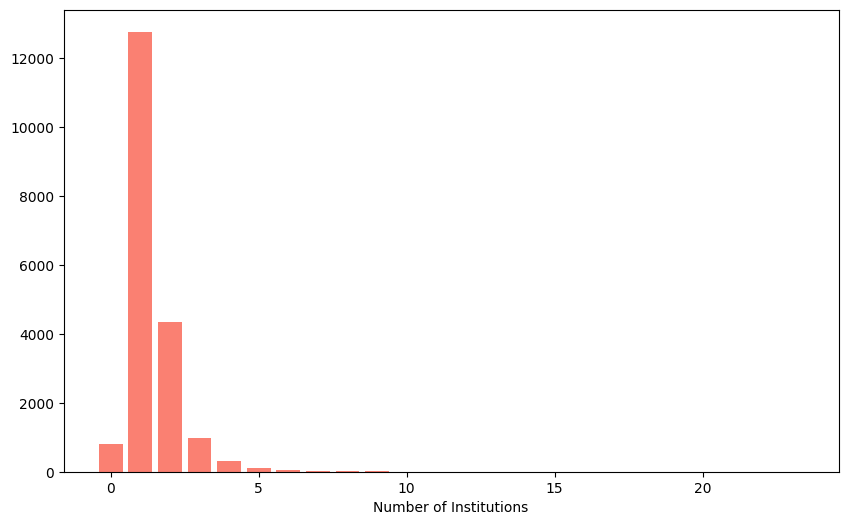

In [22]:
# Plot number of unique institutions per paper
institution_counts = Counter(len(work['authorships'][0]['institutions']) for work in all_works_2018)
institution_numbers = list(institution_counts.keys())
institution_paper_counts = list(institution_counts.values())
plt.figure(figsize=(10, 6))
plt.bar(institution_numbers, institution_paper_counts, color='salmon')
plt.xlabel('Number of Institutions')

In [23]:
# For each work generate dummy variable if at least one coauthor is from china, add it to all_works_2018
for work in all_works_2018:
    work['has_chinese_coauthor'] = any('CN' in author['countries'] for author in work['authorships'])
# Count the number of works with at least one Chinese coauthor
num_works_with_chinese_coauthor = sum(work['has_chinese_coauthor'] for work in all_works_2018)
print(f"Number of works with at least one Chinese coauthor: {num_works_with_chinese_coauthor}")
print(f"Percentage of works with at least one Chinese coauthor: {num_works_with_chinese_coauthor / num_works * 100:.2f}%")

Number of works with at least one Chinese coauthor: 925
Percentage of works with at least one Chinese coauthor: 4.77%


In [24]:
# Count the number of Chinese coauthors
chinese_coauthors = sum(
    1
    for work in all_works_2018
    for authorship in work['authorships']
    for inst in authorship.get('institutions', [])
    if inst.get('country_code') == 'CN'
)

# Print the result
print(f"Number of Chinese coauthors: {chinese_coauthors}")

Number of Chinese coauthors: 7252


In [25]:
#For each work generate dummy variable if all authors are from USA, add it to all_works_2018
for work in all_works_2018:
    work['all_authors_from_usa'] = all('US' in author['countries'] for author in work['authorships'])
# Count the number of works with all authors from the USA
num_works_all_authors_from_usa = sum(work['all_authors_from_usa'] for work in all_works_2018)
print(f"Number of works with all authors from the USA: {num_works_all_authors_from_usa}")

Number of works with all authors from the USA: 13114


## QUALITY OF RESEARCH

In [26]:
# Get min max mean and deciles of cited_by_count
cited_by_counts = [work['cited_by_count'] for work in all_works_2018]
min_cited_by_count = min(cited_by_counts)
max_cited_by_count = max(cited_by_counts)
mean_cited_by_count = np.mean(cited_by_counts)
deciles = np.percentile(cited_by_counts, np.arange(0, 101, 10))
print(f"Min cited_by_count: {min_cited_by_count}")
print(f"Max cited_by_count: {max_cited_by_count}")
print(f"Mean cited_by_count: {mean_cited_by_count:.2f}")
print(f"Deciles of cited_by_count: {deciles}")

Min cited_by_count: 0
Max cited_by_count: 3964
Mean cited_by_count: 23.35
Deciles of cited_by_count: [0.000e+00 0.000e+00 0.000e+00 1.000e+00 2.000e+00 5.000e+00 1.000e+01
 1.600e+01 2.700e+01 5.100e+01 3.964e+03]


<BarContainer object of 412 artists>

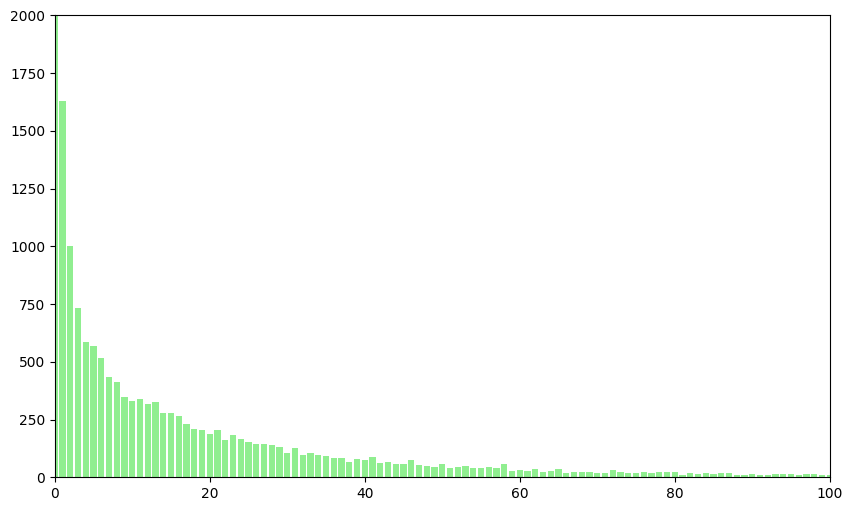

In [27]:
# Distribution of citations per paper
citations_counts = Counter(work['cited_by_count'] for work in all_works_2018)
# Prepare data for plotting
citation_numbers = list(citations_counts.keys())
citation_paper_counts = list(citations_counts.values())
# Plot the data
plt.figure(figsize=(10, 6))
plt.xlim(0, 100)
plt.ylim(0, 2000)
plt.bar(citation_numbers, citation_paper_counts, color='lightgreen')

In [28]:
#Mean citations for paperss with and without Chinese coauthors
mean_citations_with_chinese = np.mean([work['cited_by_count'] for work in all_works_2018 if work['has_chinese_coauthor']])
mean_citations_without_chinese = np.mean([work['cited_by_count'] for work in all_works_2018 if not work['has_chinese_coauthor']])
print(f"Mean citations for papers with Chinese coauthors: {mean_citations_with_chinese:.2f}")
print(f"Mean citations for papers without Chinese coauthors: {mean_citations_without_chinese:.2f}")

Mean citations for papers with Chinese coauthors: 36.94
Mean citations for papers without Chinese coauthors: 22.67


### EXPOSURE TO POLICY

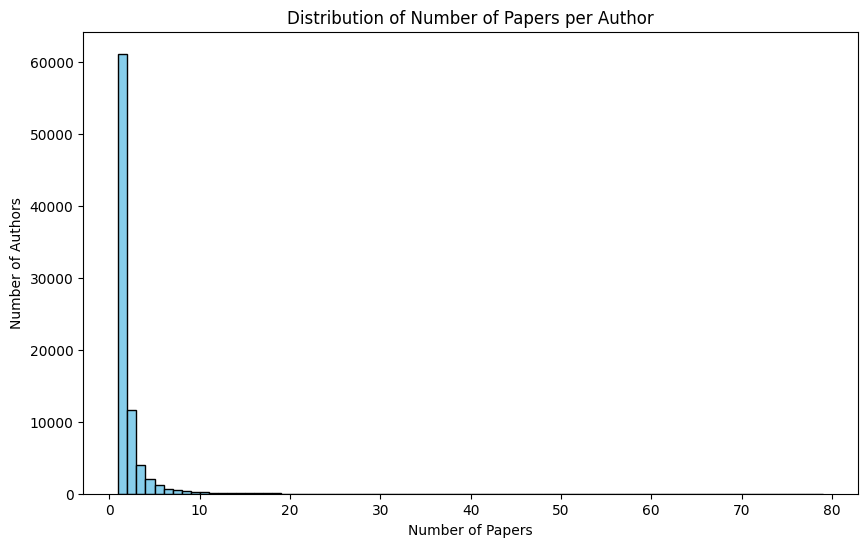

In [29]:
# Count the number of papers per author
author_paper_counts = Counter(
    authorship['author']['id']
    for work in all_works_2018
    for authorship in work['authorships']
)

# Prepare data for plotting
authors = list(author_paper_counts.keys())
paper_counts = list(author_paper_counts.values())

# Plot the data
plt.figure(figsize=(10, 6))
plt.hist(paper_counts, bins=range(1, max(paper_counts) + 2), color='skyblue', edgecolor='black')
plt.xlabel('Number of Papers')
plt.ylabel('Number of Authors')
plt.title('Distribution of Number of Papers per Author')
plt.show()

Text(0.5, 1.0, 'Distribution of Share of Papers with Chinese Coauthors for US Authors')

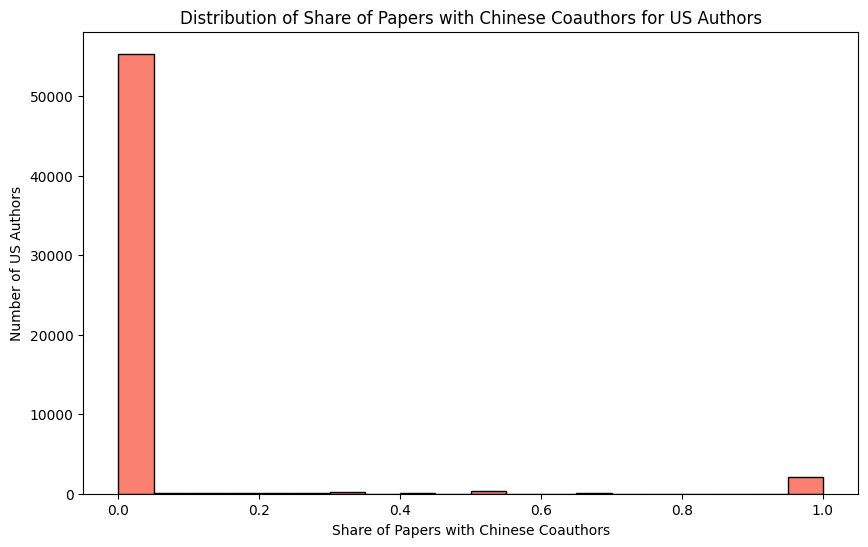

In [30]:
# For each US author compute share of papers with Chinese coauthors
for work in all_works_2018:
    for authorship in work['authorships']:
        if 'US' in authorship['countries']:
            authorship['has_chinese_coauthor'] = any('CN' in author['countries'] for author in work['authorships'])
# Count the number of papers for each US author
us_author_paper_counts = defaultdict(int)
for work in all_works_2018:
    for authorship in work['authorships']:
        if 'US' in authorship['countries']:
            us_author_paper_counts[authorship['author']['id']] += 1
# Compute the share of papers with Chinese coauthors for each US author
us_author_chinese_coauthor_counts = defaultdict(int)
for work in all_works_2018:
    for authorship in work['authorships']:
        if 'US' in authorship['countries'] and authorship.get('has_chinese_coauthor'):
            us_author_chinese_coauthor_counts[authorship['author']['id']] += 1
# Compute the share of papers with Chinese coauthors for each US author
us_author_shares = {
    author_id: us_author_chinese_coauthor_counts[author_id] / count
    for author_id, count in us_author_paper_counts.items()
}
# Prepare data for plotting
us_author_ids = list(us_author_shares.keys())
us_author_share_values = list(us_author_shares.values())
# Plot the data
plt.figure(figsize=(10, 6))
plt.hist(us_author_share_values, bins=20, color='salmon', edgecolor='black')
plt.xlabel('Share of Papers with Chinese Coauthors')
plt.ylabel('Number of US Authors')
plt.title('Distribution of Share of Papers with Chinese Coauthors for US Authors')

In [31]:
#List US authors with share of papers with Chinese coauthors > 0.5
high_share_authors = [author_id for author_id, share in us_author_shares.items() if share > 0.5]

## CHINA INITIATIVE

In [32]:
# Define the filter criteria for works published in the USA in 2020
filter_criteria = {
    "publication_year": 2019,  # Filter for works published in 2020
    "institutions": {"country_code": "us"},
    "primary_location": {"source": {"type": "journal"}},  # Filter for journal articles
    #"primary_topic": {"domain": {"id": 4}},  # Filter for Health science
    "primary_topic": {"subfield": {"id": 2740}},  # Filter for Pulmonary and Respiratory Medicine
}

# Fetch the works with pagination
query = Works().filter(**filter_criteria)
all_works_2019 = list(chain.from_iterable(query.paginate(per_page=200, n_max=None)))  # Adjust per_page as needed, n_max=None for all papers (heavy)

# Count the number of works
num_works = len(all_works_2019)

# Print the number of works
print(f"Number of works published in the USA in 2020: {num_works}")

# Optionally, print the first few works to verify
for work in all_works_2019[:5]:  # Print the first 5 works as an example
    print(f"ID: {work['id']}, Title: {work['title']}, Publication Year: {work['publication_year']}")

Number of works published in the USA in 2020: 20119
ID: https://openalex.org/W2907514116, Title: Reference-based analysis of lung single-cell sequencing reveals a transitional profibrotic macrophage, Publication Year: 2019
ID: https://openalex.org/W2925446385, Title: Pembrolizumab versus chemotherapy for previously untreated, PD-L1-expressing, locally advanced or metastatic non-small-cell lung cancer (KEYNOTE-042): a randomised, open-label, controlled, phase 3 trial, Publication Year: 2019
ID: https://openalex.org/W2913745075, Title: Pembrolizumab plus Axitinib versus Sunitinib for Advanced Renal-Cell Carcinoma, Publication Year: 2019
ID: https://openalex.org/W2980472864, Title: The CoQ oxidoreductase FSP1 acts parallel to GPX4 to inhibit ferroptosis, Publication Year: 2019
ID: https://openalex.org/W2937483840, Title: Epidemiology of Prostate Cancer, Publication Year: 2019


In [33]:
# For each work generate dummy variable if at least one coauthor is from china, add it to all_works_2020
for work in all_works_2019:
    work['has_chinese_coauthor'] = any('CN' in author['countries'] for author in work['authorships'])
# Count the number of works with at least one Chinese coauthor
num_works_with_chinese_coauthor = sum(work['has_chinese_coauthor'] for work in all_works_2019)
print(f"Number of works with at least one Chinese coauthor: {num_works_with_chinese_coauthor}")
print(f"Percentage of works with at least one Chinese coauthor: {num_works_with_chinese_coauthor / num_works * 100:.2f}%")

Number of works with at least one Chinese coauthor: 950
Percentage of works with at least one Chinese coauthor: 4.72%


In [34]:
all_works_2019[0]['grants']

[]

In [35]:
len(all_works_2019[0]['grants'])

0

In [36]:
# Add dummy variable for each work if it has a grant
for work in all_works_2019:
    work['has_grant'] = len(work['grants']) > 0
# Count the number of works with at least one grant
num_works_with_grant = sum(work['has_grant'] for work in all_works_2019)
print(f"Number of works with at least one grant: {num_works_with_grant}")

Number of works with at least one grant: 3339


Text(0.5, 1.0, 'Number of Papers for Each Number of Grants')

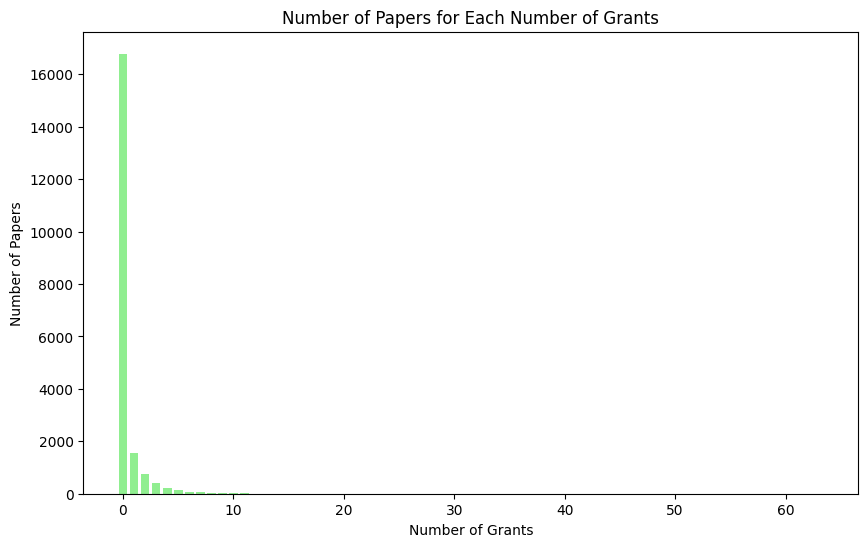

In [37]:
# Plot size of grants per paper
grant_counts = Counter(len(work['grants']) for work in all_works_2019)
# Prepare data for plotting
grant_numbers = list(grant_counts.keys())
grant_paper_counts = list(grant_counts.values())
# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(grant_numbers, grant_paper_counts, color='lightgreen')
plt.xlabel('Number of Grants')
plt.ylabel('Number of Papers')
plt.title('Number of Papers for Each Number of Grants')

In [38]:
# Comprend pas pourquoi ca marche pas (voir cellule suivante -> il y a grants)
all_works_2019['id' == 'https://openalex.org/W2990041408']['has_grant']

False

In [39]:
# Print works with grants
#for work in all_works_2019:
#   if len(work['grants']) > 0:
#        print(f"ID: {work['id']}, Has Grant: {work['has_grant']}, Grant: {work['grants']}")

In [40]:
# Print funder names and their counts
funder_counts = Counter()
for work in all_works_2019:
    for grant in work['grants']:
        funder_counts[grant['funder_display_name']] += 1
# Print the funder names and their counts
for funder, count in funder_counts.most_common(10):  # Print top 10 funders
    print(f"Funder: {funder}, Count: {count}")

Funder: National Institutes of Health, Count: 1480
Funder: National Cancer Institute, Count: 603
Funder: National Heart, Lung, and Blood Institute, Count: 523
Funder: National Natural Science Foundation of China, Count: 317
Funder: U.S. Department of Defense, Count: 142
Funder: Cystic Fibrosis Foundation, Count: 138
Funder: National Center for Advancing Translational Sciences, Count: 116
Funder: American Heart Association, Count: 101
Funder: National Institute of Diabetes and Digestive and Kidney Diseases, Count: 100
Funder: AstraZeneca, Count: 86


In [41]:
# Number of funders in funder_counts
num_funders = len(funder_counts)
print(f"Number of funders: {num_funders}")

Number of funders: 1294


In [42]:
# Top funders of works with Chinese coauthors vs without Chinese coauthors
funder_counts_with_chinese = Counter()
funder_counts_without_chinese = Counter()
for work in all_works_2019:
    for grant in work['grants']:
        if work['has_chinese_coauthor']:
            funder_counts_with_chinese[grant['funder_display_name']] += 1
        else:
            funder_counts_without_chinese[grant['funder_display_name']] += 1
# Print the top funders for works with Chinese coauthors
print("Top funders for works with Chinese coauthors:")
for funder, count in funder_counts_with_chinese.most_common(10):  # Print top 10 funders
    print(f"Funder: {funder}, Count: {count}")
# Print the top funders for works without Chinese coauthors
print("Top funders for works without Chinese coauthors:")
for funder, count in funder_counts_without_chinese.most_common(10):  # Print top 10 funders
    print(f"Funder: {funder}, Count: {count}")

Top funders for works with Chinese coauthors:
Funder: National Natural Science Foundation of China, Count: 317
Funder: National Institutes of Health, Count: 124
Funder: National Cancer Institute, Count: 30
Funder: National Heart, Lung, and Blood Institute, Count: 22
Funder: U.S. Department of Defense, Count: 20
Funder: Natural Science Foundation of Guangdong Province, Count: 15
Funder: National Institute on Aging, Count: 12
Funder: China Scholarship Council, Count: 12
Funder: Natural Science Foundation of Shandong Province, Count: 12
Funder: Natural Science Foundation of Tianjin City, Count: 11
Top funders for works without Chinese coauthors:
Funder: National Institutes of Health, Count: 1356
Funder: National Cancer Institute, Count: 573
Funder: National Heart, Lung, and Blood Institute, Count: 501
Funder: Cystic Fibrosis Foundation, Count: 133
Funder: U.S. Department of Defense, Count: 122
Funder: National Center for Advancing Translational Sciences, Count: 114
Funder: American Heart 

In [43]:
# Top funders of works with Chinese coauthors vs without Chinese coauthors
funder_counts_with_chinese = Counter()
funder_counts_without_chinese = Counter()
for work in all_works_2018:

    for grant in work['grants']:
        if work['has_chinese_coauthor']:
            funder_counts_with_chinese[grant['funder_display_name']] += 1
        else:
            funder_counts_without_chinese[grant['funder_display_name']] += 1
# Print the top funders for works with Chinese coauthors
print("Top funders for works with Chinese coauthors:")
for funder, count in funder_counts_with_chinese.most_common(10):  # Print top 10 funders
    print(f"Funder: {funder}, Count: {count}")
# Print the top funders for works without Chinese coauthors
print("Top funders for works without Chinese coauthors:")
for funder, count in funder_counts_without_chinese.most_common(10):  # Print top 10 funders
    print(f"Funder: {funder}, Count: {count}")

Top funders for works with Chinese coauthors:
Funder: National Natural Science Foundation of China, Count: 274
Funder: National Institutes of Health, Count: 145
Funder: National Cancer Institute, Count: 31
Funder: U.S. Department of Defense, Count: 27
Funder: National Heart, Lung, and Blood Institute, Count: 25
Funder: Natural Science Foundation of Guangdong Province, Count: 24
Funder: China Scholarship Council, Count: 17
Funder: National Key Research and Development Program of China, Count: 12
Funder: Ministry of Science and Technology, Taiwan, Count: 11
Funder: American Cancer Society, Count: 10
Top funders for works without Chinese coauthors:
Funder: National Institutes of Health, Count: 1340
Funder: National Heart, Lung, and Blood Institute, Count: 554
Funder: National Cancer Institute, Count: 503
Funder: Cystic Fibrosis Foundation, Count: 137
Funder: National Center for Advancing Translational Sciences, Count: 115
Funder: U.S. Department of Defense, Count: 104
Funder: National Ins

Introducing more info on fundings

## Construct networks

ne marche pas (G_fundings non défini avant)

In [44]:
# Count number of funder nodes in the graph
#num_funder_nodes = sum(1 for node, data in G_fundings.nodes(data=True) if data['type'] == 'funder')
#print(f"Number of funder nodes in the graph: {num_funder_nodes}")

ne marche pas (G_fundings non défini avant)

In [45]:
# Count number of author nodes in the graph
#num_author_nodes = sum(1 for node, data in G_fundings.nodes(data=True) if data['type'] == 'author')
#print(f"Number of author nodes in the graph: {num_author_nodes}")

In [46]:
# Count the number of authors for each work and store in all_works_2019
for work in all_works_2019:
    work['num_authors'] = len(work['authorships'])
#get total number of authors
total_coauthors = sum(work['num_authors'] for work in all_works_2019)
#get total of unique authors
unique_authors = set()
for work in all_works_2019:
    for author in work['authorships']:
        unique_authors.add(author['author']['id'])

print(f"Total number of authors: {total_coauthors}")
print(f"Total number of unique authors: {len(unique_authors)}")

Total number of authors: 147909
Total number of unique authors: 88265


SURPLUS

In [47]:
# Extract all unique country codes of co-authors
country_codes = set(
    inst.get('country_code') 
    for work in all_works_2018 
    for authorship in work['authorships'] 
    for inst in authorship.get('institutions', []) 
    if 'country_code' in inst
)

# Print the unique country codes
print(f"Different country codes of co-authors: {country_codes}")

Different country codes of co-authors: {'CO', 'NO', 'LU', 'LV', 'FR', 'SE', 'GD', 'ID', 'ET', 'KE', 'KR', 'PT', 'GE', 'AT', 'JM', 'ZM', 'RE', 'QA', 'GP', 'VE', 'US', 'GR', 'MX', 'AR', 'EG', 'TT', 'CH', 'CZ', 'MN', 'GU', 'UA', 'MM', 'RO', 'IQ', 'TJ', 'UY', 'DZ', 'NP', 'EC', 'AF', 'KG', 'VN', 'ES', 'PR', 'BE', 'KZ', 'MO', 'AU', 'PA', 'BB', None, 'NG', 'JP', 'AZ', 'RS', 'RW', 'MQ', 'AM', 'LK', 'BY', 'MC', 'TR', 'BD', 'GH', 'MD', 'TH', 'DO', 'LT', 'AE', 'SG', 'DE', 'BS', 'IL', 'KH', 'MA', 'EE', 'IS', 'RU', 'PE', 'CY', 'HK', 'NZ', 'MW', 'IR', 'CA', 'UZ', 'ZA', 'MT', 'JO', 'YE', 'MY', 'SS', 'DM', 'AL', 'BA', 'CN', 'BR', 'NL', 'HU', 'UG', 'KW', 'TZ', 'PS', 'HR', 'SY', 'PY', 'CM', 'CL', 'LB', 'MK', 'BW', 'FI', 'CU', 'PL', 'OM', 'DK', 'BG', 'PH', 'SK', 'ZW', 'IE', 'IT', 'GB', 'SI', 'TN', 'IN', 'PK', 'TW', 'CR', 'MZ', 'SA'}


In [48]:
# Count institutions in the US and outside the US
us_institutions = set(
    inst['id']
    for work in all_works_2018
    for authorship in work['authorships']
    for inst in authorship.get('institutions', [])
    if inst.get('country_code') == 'US'
)

non_us_institutions = set(
    inst['id']
    for work in all_works_2018
    for authorship in work['authorships']
    for inst in authorship.get('institutions', [])
    if inst.get('country_code') != 'US'
)

cn_institutions = set(
    inst['id']
    for work in all_works_2018
    for authorship in work['authorships']
    for inst in authorship.get('institutions', [])
    if inst.get('country_code') == 'CN'
)

# Print the results
print(f"Number of institutions in the US: {len(us_institutions)}")
print(f"Number of institutions outside the US: {len(non_us_institutions)}")
print(f"Number of institutions in China: {len(cn_institutions)}")

Number of institutions in the US: 3394
Number of institutions outside the US: 4947
Number of institutions in China: 514


## Assessing first order effects 

Top x%, jouer avec les dates de filtre

Selected 436 top China-collaborating US authors.
         pre_pubs   post_pubs  pre_china_share  post_china_share  \
count  436.000000  436.000000       436.000000        226.000000   
mean     3.222477    1.456422         0.984984          0.683606   
std      2.648539    2.746020         0.064101          0.420755   
min      2.000000    0.000000         0.500000          0.000000   
25%      2.000000    0.000000         1.000000          0.270833   
50%      2.000000    1.000000         1.000000          1.000000   
75%      3.000000    2.000000         1.000000          1.000000   
max     24.000000   24.000000         1.000000          1.000000   

       pre_foreign_share  post_foreign_share  pre_mean_citations  \
count         436.000000          226.000000          436.000000   
mean            0.290494            0.313015           63.063660   
std             0.385110            0.408912          144.485293   
min             0.000000            0.000000            0.000000  

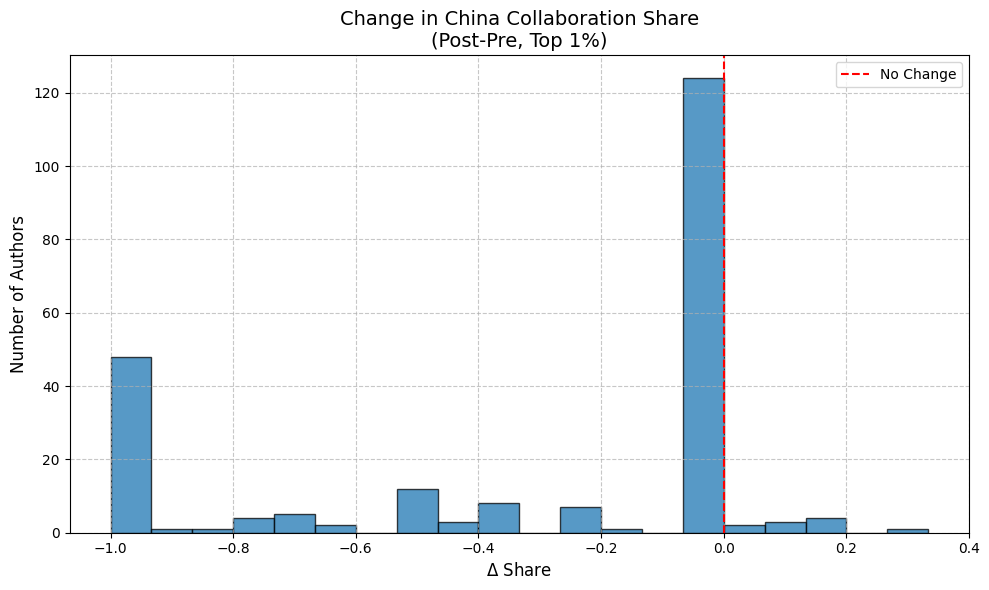

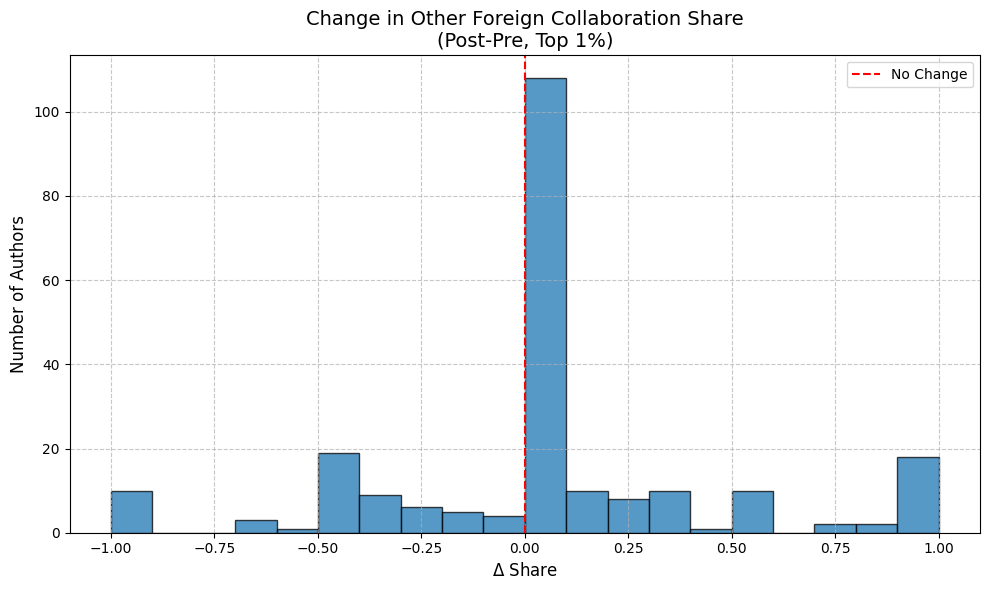

In [76]:
import numpy as np
import pandas as pd
from collections import defaultdict

# ========================
# Step 1: Select Top X% of China-collaborating US researchers (before Nov 2018)
# ========================

# Build US authors + share of papers with Chinese coauthors
us_author_total_papers_pre = defaultdict(int)
us_author_chinese_papers_pre = defaultdict(int)

for work in all_works_16_20:  # assuming you already have all works 2016-2020
    if work['publication_year'] < 2019:  # Before Nov 2018 => anything up to 2018
        for authorship in work['authorships']:
            if 'US' in authorship['countries']:
                us_author_total_papers_pre[authorship['author']['id']] += 1
                if any('CN' in coauth['countries'] for coauth in work['authorships']):
                    us_author_chinese_papers_pre[authorship['author']['id']] += 1

# Compute share of China collaboration
us_author_china_share = {
    author_id: us_author_chinese_papers_pre[author_id] / us_author_total_papers_pre[author_id]
    for author_id in us_author_total_papers_pre
    if us_author_total_papers_pre[author_id] >= 2  # filter for active researchers
}

# Find top X% most China-collaborative authors
top_percentage = 1
threshold = np.percentile(list(us_author_china_share.values()), 100 - top_percentage)
top_china_authors = {author_id for author_id, share in us_author_china_share.items() if share >= threshold}

print(f"Selected {len(top_china_authors)} top China-collaborating US authors.")

# ========================
# Step 2: Track outcomes before vs after Nov 2018
# ========================

# Initialize metrics
author_metrics = defaultdict(lambda: {
    'pre_pubs': 0, 'post_pubs': 0,
    'pre_china_pubs': 0, 'post_china_pubs': 0,
    'pre_other_foreign_pubs': 0, 'post_other_foreign_pubs': 0,
    'pre_citations': [], 'post_citations': []
})

for work in all_works_16_20:
    year = work['publication_year']
    if year < 2016 or year > 2020:
        continue  # skip

    is_pre = (year <= 2018)  # Pre-shock = 2016–2018
    is_post = (year >= 2019)  # Post-shock = 2019–2020

    has_chinese_coauthor = any('CN' in auth['countries'] for auth in work['authorships'])
    has_other_foreign_coauthor = any(
        c not in ['US', 'CN'] for auth in work['authorships'] for c in auth['countries']
    )

    for authorship in work['authorships']:
        author_id = authorship['author']['id']
        if author_id in top_china_authors:
            if is_pre:
                author_metrics[author_id]['pre_pubs'] += 1
                if has_chinese_coauthor:
                    author_metrics[author_id]['pre_china_pubs'] += 1
                if has_other_foreign_coauthor:
                    author_metrics[author_id]['pre_other_foreign_pubs'] += 1
                author_metrics[author_id]['pre_citations'].append(work['cited_by_count'])
            elif is_post:
                author_metrics[author_id]['post_pubs'] += 1
                if has_chinese_coauthor:
                    author_metrics[author_id]['post_china_pubs'] += 1
                if has_other_foreign_coauthor:
                    author_metrics[author_id]['post_other_foreign_pubs'] += 1
                author_metrics[author_id]['post_citations'].append(work['cited_by_count'])

# ========================
# Step 3: Prepare clean table
# ========================

# Build a dataframe
rows = []
for author_id, metrics in author_metrics.items():
    rows.append({
        'author_id': author_id,
        'pre_pubs': metrics['pre_pubs'],
        'post_pubs': metrics['post_pubs'],
        'pre_china_share': metrics['pre_china_pubs'] / metrics['pre_pubs'] if metrics['pre_pubs'] > 0 else np.nan,
        'post_china_share': metrics['post_china_pubs'] / metrics['post_pubs'] if metrics['post_pubs'] > 0 else np.nan,
        'pre_foreign_share': metrics['pre_other_foreign_pubs'] / metrics['pre_pubs'] if metrics['pre_pubs'] > 0 else np.nan,
        'post_foreign_share': metrics['post_other_foreign_pubs'] / metrics['post_pubs'] if metrics['post_pubs'] > 0 else np.nan,
        'pre_mean_citations': np.mean(metrics['pre_citations']) if metrics['pre_citations'] else np.nan,
        'post_mean_citations': np.mean(metrics['post_citations']) if metrics['post_citations'] else np.nan,
    })

df_metrics = pd.DataFrame(rows)

# ========================
# Step 4: Analysis
# ========================

# Change in collaborations
df_metrics['delta_china_share'] = df_metrics['post_china_share'] - df_metrics['pre_china_share']
df_metrics['delta_foreign_share'] = df_metrics['post_foreign_share'] - df_metrics['pre_foreign_share']

# Change in publications
df_metrics['delta_pubs'] = df_metrics['post_pubs'] - df_metrics['pre_pubs']

# Change in citations
df_metrics['delta_mean_citations'] = df_metrics['post_mean_citations'] - df_metrics['pre_mean_citations']

# Summary
print(df_metrics.describe())

import matplotlib.pyplot as plt

# Settings
figsize = (10, 6)
bins = 20
alpha = 0.75
edgecolor = 'black'

# Plot for China collaboration share
plt.figure(figsize=figsize)
plt.hist(df_metrics['delta_china_share'].dropna(), bins=bins, alpha=alpha, edgecolor=edgecolor)
plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5, label='No Change')
plt.title(f'Change in China Collaboration Share\n(Post-Pre, Top {top_percentage}%)', fontsize=14)
plt.xlabel(r'$\Delta$ Share', fontsize=12)  # <-- Greek Delta here
plt.ylabel('Number of Authors', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Plot for Other Foreign collaboration share
plt.figure(figsize=figsize)
plt.hist(df_metrics['delta_foreign_share'].dropna(), bins=bins, alpha=alpha, edgecolor=edgecolor)
plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5, label='No Change')
plt.title(f'Change in Other Foreign Collaboration Share\n(Post-Pre, Top {top_percentage}%)', fontsize=14)
plt.xlabel(r'$\Delta$ Share', fontsize=12)  # <-- Greek Delta here
plt.ylabel('Number of Authors', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

**Computing various indicators pre/post such as homophily**

In [50]:
# === COMPUTE NETWORK INDICATORS ===

# 1. Degree Centrality (Number of Coauthors)
author_degree = dict(G_collaboration.degree())
nx.set_node_attributes(G_collaboration, author_degree, 'degree')

# 2. Betweenness Centrality (Brokers and Bridges)
#author_betweenness = nx.betweenness_centrality(G_collaboration, normalized=True)
#nx.set_node_attributes(G_collaboration, author_betweenness, 'betweenness')


# 3. Local Clustering Coefficient (Cohesion among coauthors)
author_clustering = nx.clustering(G_collaboration)
nx.set_node_attributes(G_collaboration, author_clustering, 'clustering')

# 4. Homophily Index (Nationality Diversity, Blau Index)
author_homophily = {}
for node in G_collaboration.nodes():
    neighbors = list(G_collaboration.neighbors(node))
    countries = []
    for n in neighbors:
        countries += G_collaboration.nodes[n].get('country', [])  # Expecting list of countries
    if countries:
        country_counts = Counter(countries)
        total = sum(country_counts.values())
        blau_index = 1 - sum((count / total) ** 2 for count in country_counts.values())
        author_homophily[node] = blau_index
    else:
        author_homophily[node] = np.nan  # no neighbors
nx.set_node_attributes(G_collaboration, author_homophily, 'homophily_blau')

# === BUILD FINAL AUTHOR METRICS TABLE ===

authors_data = []
for node, data in G_collaboration.nodes(data=True):
    if data.get('country') is not None:  # Keep real authors
        authors_data.append({
            'author_id': node,
            'degree': data.get('degree', np.nan),
            #'betweenness': data.get('betweenness', np.nan),
            'clustering': data.get('clustering', np.nan),
            'homophily_blau': data.get('homophily_blau', np.nan),
        })

df_authors_metrics = pd.DataFrame(authors_data)

print("✅ Network indicators computed successfully!")
print(df_authors_metrics.head())


✅ Network indicators computed successfully!
                          author_id  degree  clustering  homophily_blau
0  https://openalex.org/A5059063118     383    0.072943        0.604788
1  https://openalex.org/A5058115259     199    0.132328        0.450294
2  https://openalex.org/A5006249276     153    0.455280        0.881747
3  https://openalex.org/A5071853292      85    0.310084        0.870390
4  https://openalex.org/A5009523282      51    0.525490        0.777393


## More network analysis

### Core-Perihery analysis

In [51]:
all_works_2019 = [work for work in all_works_16_20 if work['publication_year'] == 2019]
num_works = len(all_works_2019)

In [67]:
# Construct a collaboration network with country information
G_collaboration_2019 = nx.Graph()

# Add nodes and edges for authors
for work in all_works_2019:
    authors = [
        (authorship['author']['id'], authorship['countries'])  # Assuming the first country is the primary one
        for authorship in work['authorships']
    ]
    for i, (author1, country1) in enumerate(authors):
        # Add author1 node with country attribute
        G_collaboration_2019.add_node(author1, country=country1)
        for author2, country2 in authors[i + 1:]:
            # Add author2 node with country attribute
            G_collaboration_2019.add_node(author2, country=country2)
            # Add edge between author1 and author2
            if G_collaboration_2019.has_edge(author1, author2):
                G_collaboration_2019[author1][author2]['weight'] += 1
            else:
                G_collaboration_2019.add_edge(author1, author2, weight=1)

In [80]:
G_collaboration_2018 = G_collaboration.copy()

In [81]:
def compute_coreness(G):
    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))
    # Compute coreness scores
    coreness = nx.core_number(G)
    return coreness

def average_coreness(coreness):
        return np.mean(list(coreness.values()))

def average_coreness_top_china(coreness, top_china_authors):
    return np.mean([coreness[author] for author in top_china_authors if author in coreness])

In [83]:
# Assuming G_collaboration_2019 is your graph for 2019
# Assuming top_china_authors is your list of top China authors

# Compute coreness for 2019
coreness_2019 = compute_coreness(G_collaboration_2019)
coreness_2018 = compute_coreness(G_collaboration_2018)

avg_coreness_overall_2019 = average_coreness(coreness_2019)
avg_coreness_topUSCN_2019 = average_coreness_top_china(coreness_2019, top_china_authors)
avg_coreness_overall_2018 = average_coreness(coreness_2018)
avg_coreness_topUSCN_2018 = average_coreness_top_china(coreness_2018, top_china_authors)

# Print results in a table format
print(f"{'Average coreness score':<30} {'2018':<10} {'2019':<10}")
print(f"{'Overall':<30} {avg_coreness_overall_2018:<10.2f} {avg_coreness_overall_2019:<10.2f}")
print(f"{'Top US-CN Authors':<30} {avg_coreness_topUSCN_2018:<10.2f} {avg_coreness_topUSCN_2019:<10.2f}")

Average coreness score         2018       2019      
Overall                        13.82      14.53     
Top US-CN Authors              13.04      12.65     


### Disruption Analysis

In [ ]:
# List countries with the most collaborations with the US
country_collaboration_counts = Counter()
for work in all_works_2018:
    for authorship in work['authorships']:
        for inst in authorship.get('institutions', []):
            if 'US' in authorship['countries'] and inst.get('country_code') != 'US':
                country_collaboration_counts[inst['country_code']] += 1
# Print the top 10 countries with the most collaborations with the US
print("Top 10 countries with the most collaborations with the US:")
for country, count in country_collaboration_counts.most_common(10):  # Print top 10 countries
    print(f"{country}: {count} collaborations")

Top 10 countries with the most collaborations with the US:
None: 2367 collaborations
CN: 1362 collaborations
GB: 1348 collaborations
FR: 684 collaborations
CA: 640 collaborations
DE: 633 collaborations
JP: 547 collaborations
IT: 477 collaborations
NL: 460 collaborations
KR: 343 collaborations


In [90]:
def calculate_us_country_disruption(G_pre, G_post, country):
    # Get US and Chinese author nodes
    us_authors = [n for n, d in G_pre.nodes(data=True) if 'US' in d.get('country', [])]
    country_authors = [n for n, d in G_pre.nodes(data=True) if country in d.get('country', [])]
    
    # Identify US-China collaboration edges in pre-period
    us_country_edges = set((u, v) for u in us_authors for v in country_authors if G_pre.has_edge(u, v))
    
    # Find disrupted collaborations
    disrupted = [edge for edge in us_country_edges 
                if not G_post.has_edge(*edge)]
    
    return len(disrupted)/len(us_country_edges) if us_country_edges else 0

In [97]:
# List of country codes
country_codes = ['CN', 'FR', 'CA', 'JP']
#country_codes = ['CN', 'GB', 'FR', 'CA', 'JP']

# Calculate disruption rates for each country
disruption_rates = {
    country: calculate_us_country_disruption(G_collaboration, G_collaboration_2019, country)
    for country in country_codes
}

# Print results in a table format
print(f"{'Country':<10} {'US-Country Collaboration Disruption Rate':<35}")
for country, rate in disruption_rates.items():
    print(f"{f'US-{country}':<10} {rate:.2%}")



Country    US-Country Collaboration Disruption Rate
US-CN      91.03%
US-FR      87.50%
US-CA      86.35%
US-JP      86.93%


## Top US-CN authors network

CAREFUL: nodes with no edges: published years before 2018

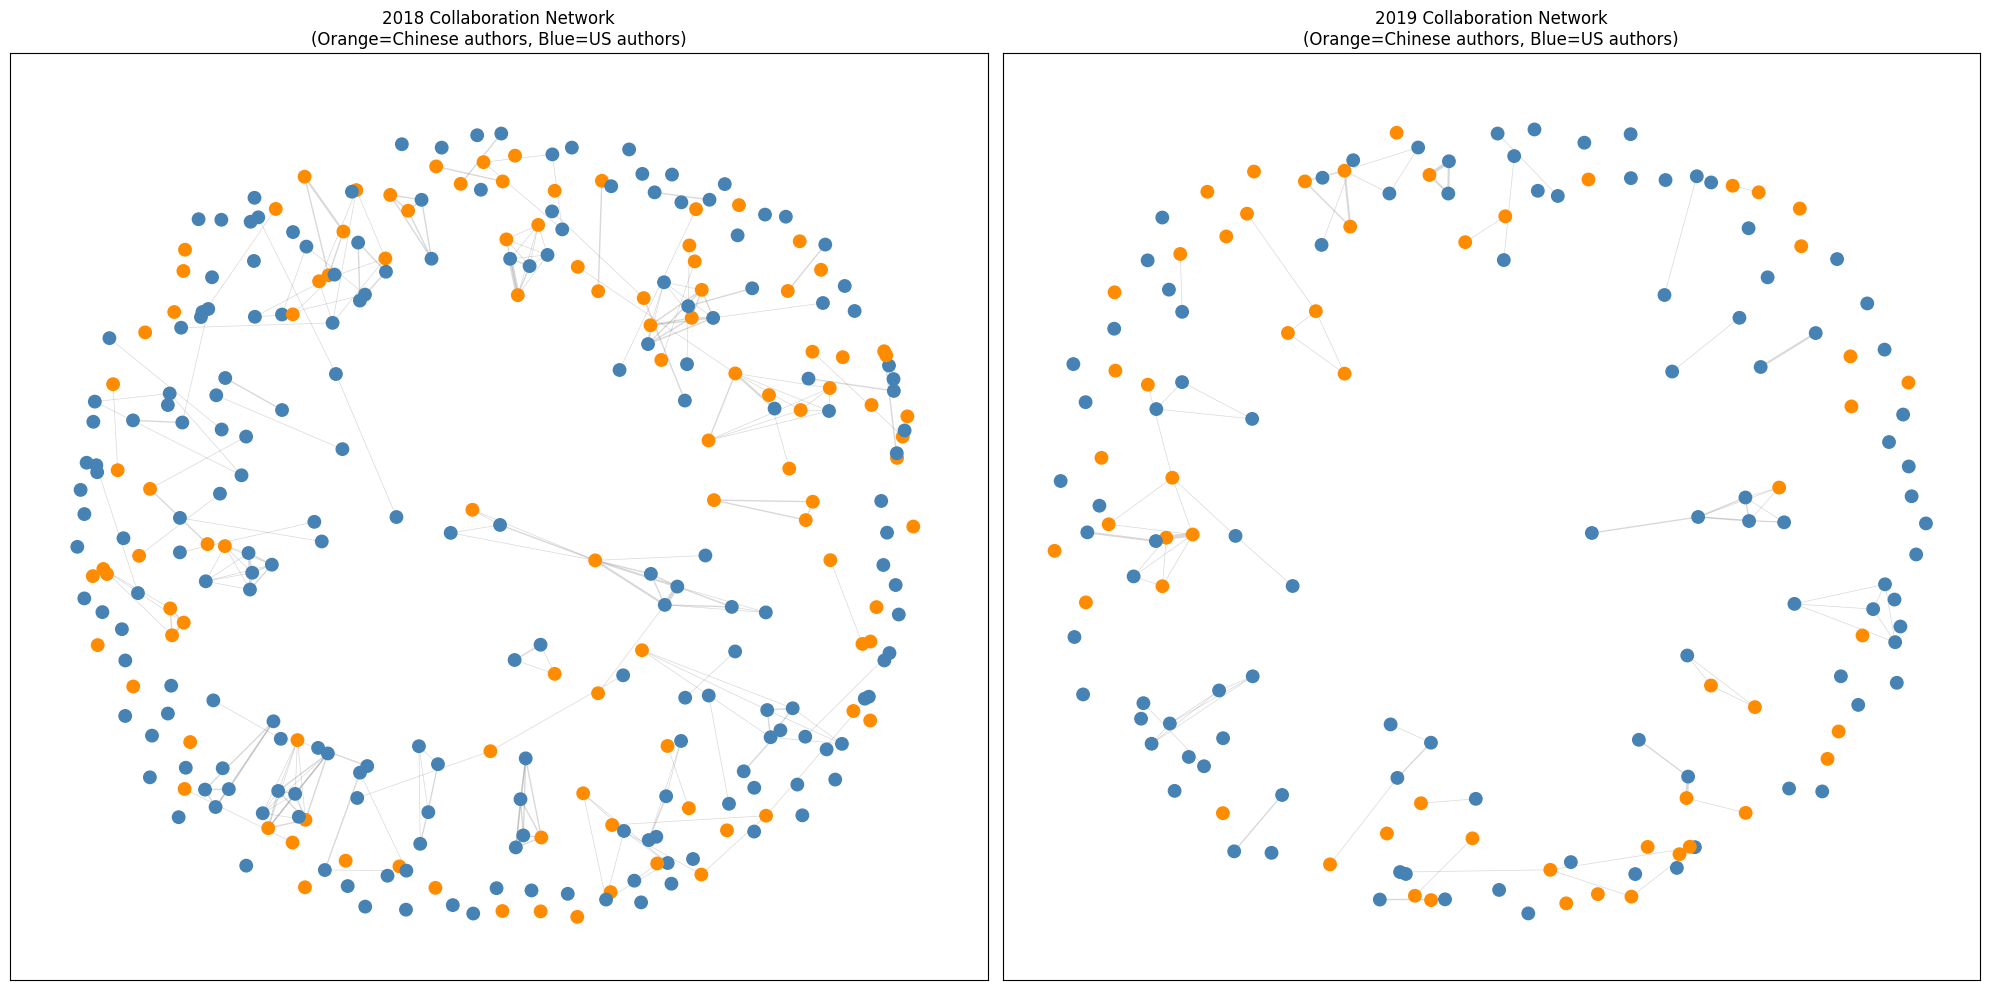

In [ ]:
# Create induced subgraphs for both years including edges
sub_2018 = G_collaboration_2018.subgraph(top_china_authors)
sub_2019 = G_collaboration_2019.subgraph(top_china_authors)

# Compute layouts using edge weights for better spacing
pos_2018 = nx.spring_layout(sub_2018, weight='weight', seed=42, k=0.3)
pos_2019 = nx.spring_layout(sub_2019, weight='weight', seed=42, k=0.3)

# Plot side-by-side with weighted edges
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

# 2018 Network
edge_widths_2018 = [sub_2018[u][v]['weight']*0.5 for u,v in sub_2018.edges()]
nx.draw_networkx_edges(sub_2018, pos_2018, ax=ax1, alpha=0.3, width=edge_widths_2018, edge_color='gray')
nx.draw_networkx_nodes(sub_2018, pos_2018, ax=ax1, node_size=80,
                       node_color=['darkorange' if 'CN' in sub_2018.nodes[node].get('country', []) 
                                   else 'steelblue' for node in sub_2018.nodes])
ax1.set_title("2018 Collaboration Network\n(Orange=Chinese authors, Blue=US authors)")

# 2019 Network
edge_widths_2019 = [sub_2019[u][v]['weight']*0.5 for u,v in sub_2019.edges()]
nx.draw_networkx_edges(sub_2019, pos_2019, ax=ax2, alpha=0.3, width=edge_widths_2019, edge_color='gray')
nx.draw_networkx_nodes(sub_2019, pos_2019, ax=ax2, node_size=80,
                       node_color=['darkorange' if 'CN' in sub_2019.nodes[node].get('country', [])
                                   else 'steelblue' for node in sub_2019.nodes])
ax2.set_title("2019 Collaboration Network\n(Orange=Chinese authors, Blue=US authors)")

plt.tight_layout()
plt.show()


In [130]:
# Filter US authors for 2018 and 2019
us_authors_2018 = [n for n, d in G_collaboration_2018.nodes(data=True) if 'US' in d.get('country', []) and n in top_china_authors]
us_authors_2019 = [n for n, d in G_collaboration_2019.nodes(data=True) if 'US' in d.get('country', []) and n in top_china_authors]

# Find authors present in both years
common_authors = [n for n in us_authors_2018 if n in us_authors_2019]

if common_authors:
    # Calculate the degree multiplied by the share of Chinese coauthors for each common author
    author_metrics = []
    for author in common_authors:
        neighbors_2018 = list(G_collaboration_2018.neighbors(author))
        cn_neighbors_2018 = [n for n in neighbors_2018 if 'CN' in G_collaboration_2018.nodes[n].get('country', [])]
        share_cn_collaborators = len(cn_neighbors_2018) / len(neighbors_2018) if neighbors_2018 else 0
        degree_2018 = G_collaboration_2018.degree(author)
        degree_share_product = degree_2018 * share_cn_collaborators
        author_metrics.append((author, degree_share_product, degree_2018, share_cn_collaborators))

    if author_metrics:
        # Find the author with the highest degree multiplied by the share of Chinese coauthors
        highest_degree_share_author = max(author_metrics, key=lambda x: x[1])
        author, degree_share_product, degree, share_cn = highest_degree_share_author

        print(f"US author with highest degree multiplied by share of CN coauthors in 2018 (also in 2019): {author}")
        print(f"Degree: {degree}")
        print(f"Share of CN collaborators: {share_cn:.2%}")
        print(f"Degree * Share of CN collaborators: {degree_share_product:.2f}")
    else:
        print("No authors found with a share of CN collaborators below 100%.")
else:
    print("No common US authors found in both 2018 and 2019.")


US author with highest degree multiplied by share of CN coauthors in 2018 (also in 2019): https://openalex.org/A5044949766
Degree: 50
Share of CN collaborators: 64.00%
Degree * Share of CN collaborators: 32.00


In [131]:
G_collaboration_2018.remove_edges_from(nx.selfloop_edges(G_collaboration_2018))
G_collaboration_2019.remove_edges_from(nx.selfloop_edges(G_collaboration_2019))

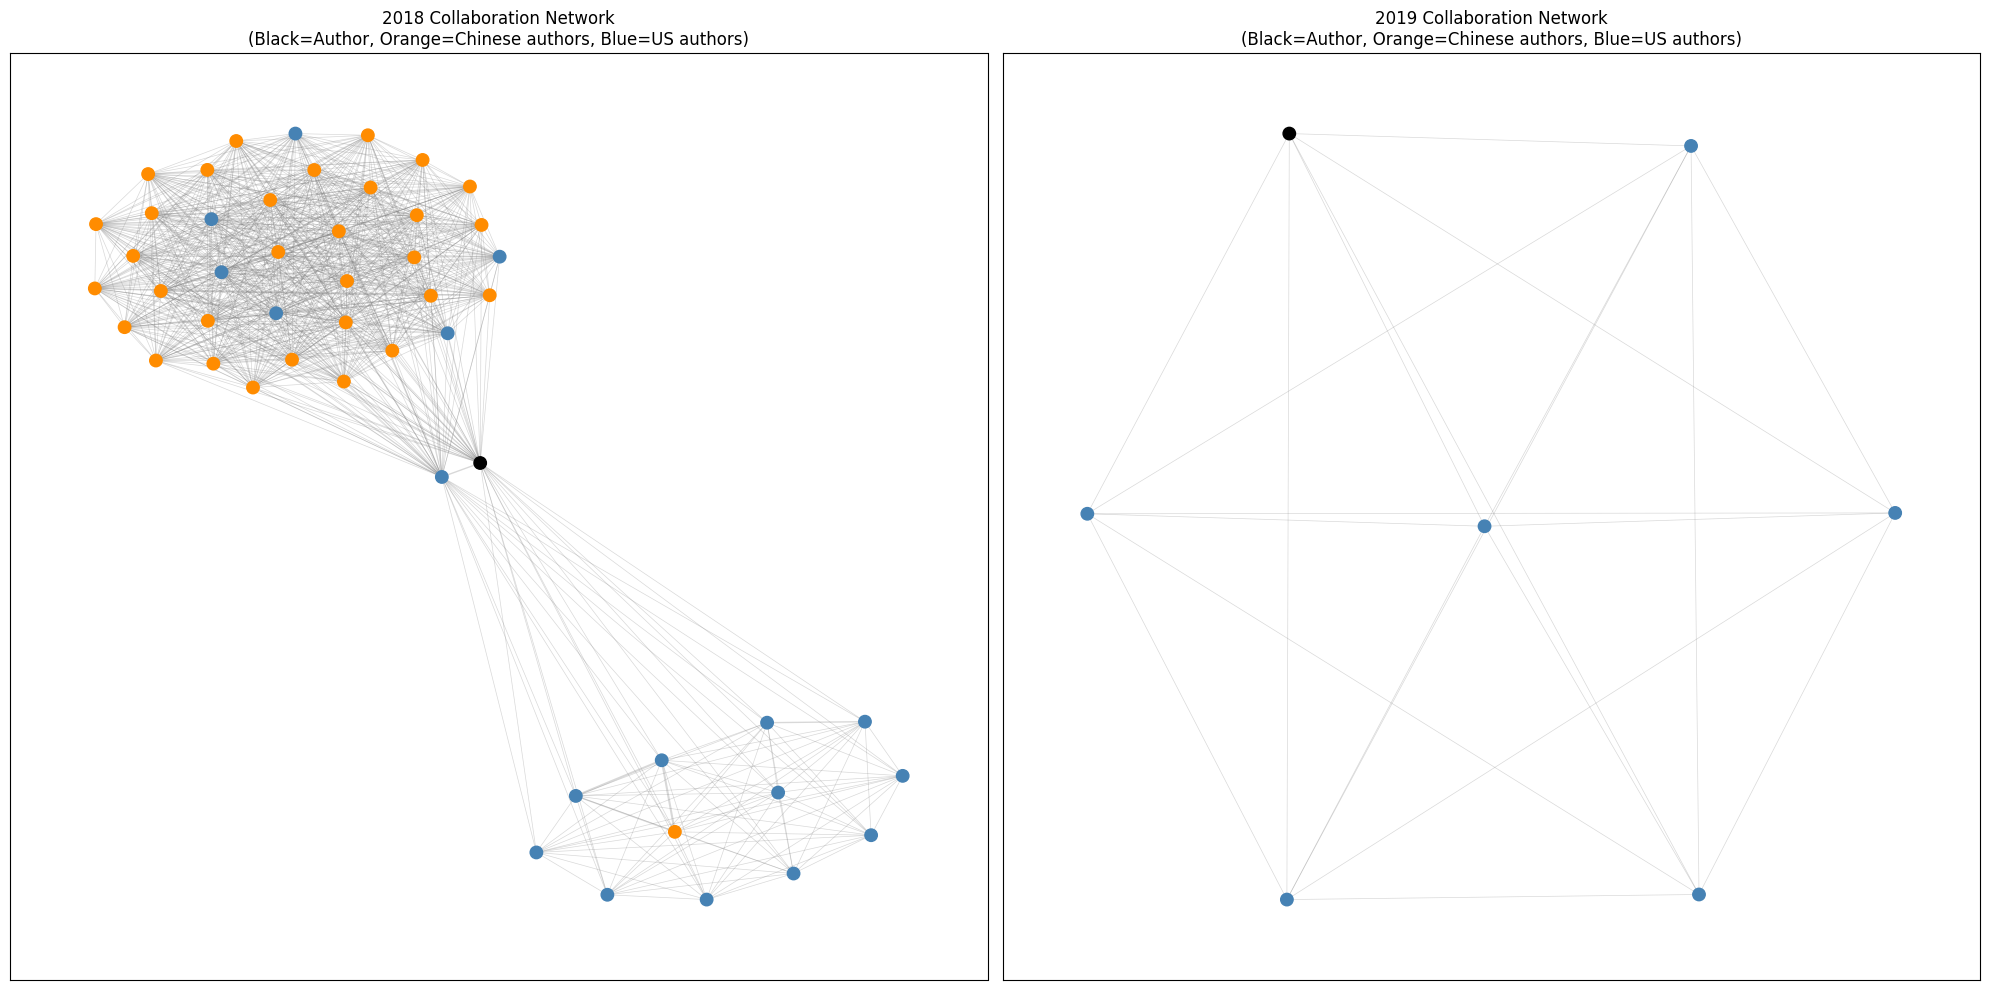

In [132]:
# Visualize the network of highest_us_author_2018 in 2018 and in 2019
sub_2018_highest = G_collaboration_2018.neighbors(author)
sub_2019_highest = G_collaboration_2019.neighbors(author)

# Create induced subgraphs for both years including edges
sub_2018_highest = G_collaboration_2018.subgraph([author] + list(sub_2018_highest))
sub_2019_highest = G_collaboration_2019.subgraph([author] + list(sub_2019_highest))

# Compute layouts using edge weights for better spacing
pos_2018_highest = nx.spring_layout(sub_2018_highest, weight='weight', seed=42, k=0.3)
pos_2019_highest = nx.spring_layout(sub_2019_highest, weight='weight', seed=42, k=0.3)

# Plot side-by-side with weighted edges
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# 2018 Network
edge_widths_2018_highest = [sub_2018_highest[u][v]['weight'] * 0.5 for u, v in sub_2018_highest.edges()]
nx.draw_networkx_edges(sub_2018_highest, pos_2018_highest, ax=ax1, alpha=0.3, width=edge_widths_2018_highest, edge_color='gray')
node_colors_2018 = [
    'black' if node == author else
    'darkorange' if 'CN' in sub_2018_highest.nodes[node].get('country', []) else
    'steelblue' for node in sub_2018_highest.nodes
]
nx.draw_networkx_nodes(sub_2018_highest, pos_2018_highest, ax=ax1, node_size=80, node_color=node_colors_2018)
ax1.set_title("2018 Collaboration Network\n(Black=Author, Orange=Chinese authors, Blue=US authors)")

# 2019 Network
edge_widths_2019_highest = [sub_2019_highest[u][v]['weight'] * 0.5 for u, v in sub_2019_highest.edges()]
nx.draw_networkx_edges(sub_2019_highest, pos_2019_highest, ax=ax2, alpha=0.3, width=edge_widths_2019_highest, edge_color='gray')
node_colors_2019 = [
    'black' if node == author else
    'darkorange' if 'CN' in sub_2019_highest.nodes[node].get('country', []) else
    'steelblue' for node in sub_2019_highest.nodes
]
nx.draw_networkx_nodes(sub_2019_highest, pos_2019_highest, ax=ax2, node_size=80, node_color=node_colors_2019)
ax2.set_title("2019 Collaboration Network\n(Black=Author, Orange=Chinese authors, Blue=US authors)")

plt.tight_layout()
plt.show()


In [140]:
# Compute distance between 2018 and 2019 networks of the author
def compute_distance_between_years(G1, G2, author):
    # Get neighbors of the author in both years
    neighbors_2018 = set(G1.neighbors(author))
    neighbors_2019 = set(G2.neighbors(author))

    # Compute Jaccard distance
    intersection = len(neighbors_2018.intersection(neighbors_2019))
    union = len(neighbors_2018.union(neighbors_2019))

    if union == 0:
        return 0.0  # No neighbors in either year

    jaccard_distance = 1 - (intersection / union)
    return jaccard_distance
# Compute distance for the author
distance = compute_distance_between_years(G_collaboration_2018, G_collaboration_2019, author)
print(f"Jaccard distance between 2018 and 2019 networks for author {author}: {distance:.2f}")

# What share of coauthors of "author" in 2019 are new coauthors (not in 2018)?
coauthors_2018 = set(G_collaboration_2018.neighbors(author))
coauthors_2019 = set(G_collaboration_2019.neighbors(author))
new_coauthors_2019 = coauthors_2019 - coauthors_2018
share_new_coauthors = len(new_coauthors_2019) / len(coauthors_2019) if coauthors_2019 else 0
print(f"Share of new coauthors in 2019 for author {author}: {share_new_coauthors:.2%}")

# Are individuals in new_coauthors_2019, observed in 2018?
new_coauthors_2019_in_2018 = [coauthor for coauthor in new_coauthors_2019 if coauthor in G_collaboration_2018.nodes()]
print(f"New coauthors in 2019 for author {author} who were also observed in 2018: {new_coauthors_2019_in_2018}")

# What was the mean distance between the author and authors in new_coauthors_2019, in 2018?
def compute_mean_distance(G, author, new_coauthors):
    distances = []
    for coauthor in new_coauthors:
        if G.has_node(coauthor) and G.has_node(author):
            try:
                distance = nx.shortest_path_length(G, source=author, target=coauthor)
                distances.append(distance)
            except nx.NetworkXNoPath:
                continue  # No path exists between author and coauthor
    return np.mean(distances) if distances else np.nan
mean_distance_2018 = compute_mean_distance(G_collaboration_2018, author, new_coauthors_2019)
print(f"Mean distance to new coauthors in 2018 for author {author}: {mean_distance_2018:.2f}")

Jaccard distance between 2018 and 2019 networks for author https://openalex.org/A5044949766: 0.98
Share of new coauthors in 2019 for author https://openalex.org/A5044949766: 83.33%
New coauthors in 2019 for author https://openalex.org/A5044949766 who were also observed in 2018: []
Mean distance to new coauthors in 2018 for author https://openalex.org/A5044949766: nan


## Fill the blank

In [141]:
# Density and mean degree of the network in 2018
density_2018 = nx.density(G_collaboration_2018)
mean_degree_2018 = np.mean([d for n, d in G_collaboration_2018.degree()])
print(f"Density of the network in 2018: {density_2018:.4f}")
print(f"Mean degree of the network in 2018: {mean_degree_2018:.2f}")

Density of the network in 2018: 0.0002
Mean degree of the network in 2018: 17.30


In [142]:
# Range of degree centrality in 2018
degree_centrality_2018 = dict(G_collaboration_2018.degree())
degree_values_2018 = list(degree_centrality_2018.values())
degree_range_2018 = (min(degree_values_2018), max(degree_values_2018))
print(f"Range of degree centrality in 2018: {degree_range_2018[0]} - {degree_range_2018[1]}")

Range of degree centrality in 2018: 0 - 546


## Trying to plot the graph with datashader

## Trying to plot the graph with datashader

In [ ]:
# === INSTALL IF NEEDED ===
# !pip install -U datashader holoviews bokeh

# === IMPORTS ===
import holoviews as hv
import datashader as ds
import datashader.transfer_functions as tf
import networkx as nx
import pandas as pd
import numpy as np

hv.extension('bokeh')

# === STEP 1: BUILD SPRING LAYOUT ===
print("Computing layout for G_collaboration... (this can take a few minutes)")
try:
    pos = nx.spring_layout(G_collaboration, seed=42, k=1/np.sqrt(G_collaboration.number_of_nodes()))
except MemoryError:
    print("MemoryError: using spectral layout instead...")
    pos = nx.spectral_layout(G_collaboration)

# Create DataFrames for nodes and edges
print("Building DataFrames...")
nodes_df = pd.DataFrame({
    'x': [pos[node][0] for node in G_collaboration.nodes()],
    'y': [pos[node][1] for node in G_collaboration.nodes()],
})

edges_x = []
edges_y = []
for u, v in G_collaboration.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edges_x.append([x0, x1])
    edges_y.append([y0, y1])

edges_df = pd.DataFrame({
    'x0': [p[0] for p in edges_x],
    'y0': [p[0] for p in edges_y],
    'x1': [p[1] for p in edges_x],
    'y1': [p[1] for p in edges_y],
})

# === STEP 2: PLOT USING DATASHADER ===
print("Rendering with Datashader...")

canvas = ds.Canvas(plot_width=1200, plot_height=1200)

# Plot edges
agg_edges = canvas.line(edges_df, 'x0', 'y0', 'x1', 'y1', agg=ds.count())

# Plot nodes separately (optional, because usually edges dominate)
agg_nodes = canvas.points(nodes_df, 'x', 'y', agg=ds.count())

# Combine edges and nodes
img_edges = tf.shade(agg_edges, cmap=["lightblue", "darkblue"], how='log')
img_nodes = tf.shade(agg_nodes, cmap=["orange", "red"], how='log')

final_img = tf.stack(img_edges, img_nodes)

# Display
hv.output(size=200)
hv.Image(final_img)